# Foundations of Computational Economics #40

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Consumption-savings model with continuous choice

<img src="_static/img/lab.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/vqByuqOJKJs](https://youtu.be/vqByuqOJKJs)

Description: Adding continuous version of Bellman operator and time iterations solver to the consumption-savings model.  Measuring accuracy of different solutions.

1. Continue developing the `deaton` class implementing the stochastic consumption-savings model:  
  - add implementation of the Bellman equation with non-discretized choices  
  - add Euler residual calculation  
  - add time iterations solver  
  - add accuracy measurement to compare solutions  
1. Compare accuracy of solutions using squared Euler residuals:  
  - VFI with discretized choices, several interpolation schemes  
  - VFI with continuous choices, several interpolation schemes  
  - Time iterations, several interpolation schemes  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate
from scipy.stats import lognorm
from scipy.optimize import minimize_scalar, brentq

class deaton():
    '''Implementation of the stochastic Deaton consumption-savings problem with random income.'''

    def __init__(self, Mbar=10,
                 ngrid=50, nchgrid=100, nquad=10,
                 interpolation='linear', bellman_type='discretized',
                 maxiter_internal=250, tol_internal=1e-10,
                 beta=.9, R=1.05, sigma=1.):
        '''Object creator for the stochastic consumption-savings model'''
        self.beta = beta        # Discount factor
        self.R = R              # Gross interest
        self.sigma = sigma      # Param in log-normal income distribution
        self.Mbar = Mbar        # Upper bound on wealth
        self.ngrid = ngrid      # Number of grid points in the state space
        self.nchgrid = nchgrid  # Number of grid points in the decision space
        self.nquad = nquad      # Number of quadrature points
        self.interpolation = interpolation  # type of interpolation, see below
        self.bellman_type = bellman_type  # type of Bellman operator
        self.maxiter_internal = maxiter_internal  # maxiter for continuous Bellman operator
        self.tol_internal = tol_internal  # tolerance for continuous Bellman operator
        # state and choice space grids, as well as quadrature points and weights are set with setter functions below

    def __repr__(self):
        '''String representation for the model'''
        return 'Deaton model with beta={:1.3f}, sigma={:1.3f}, gross return={:1.3f}\nGrids: state {} points up to {:1.1f}, choice {} points, quadrature {} points\nInterpolation: {}\nThe model is {}solved.'\
               .format(self.beta,self.sigma,self.R,self.ngrid,self.Mbar,self.nchgrid,self.nquad,self.interpolation,'' if hasattr(self,'solution') else 'not ')

    @property
    def ngrid(self):
        '''Property getter for the ngrid parameter'''
        return self.__ngrid

    @ngrid.setter
    def ngrid(self,ngrid):
        '''Property setter for the ngrid parameter'''
        self.__ngrid = ngrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.grid = np.linspace(epsilon,self.Mbar,ngrid) # grid for state space

    @property
    def nchgrid(self):
        '''Property getter for the nchgrid parameter'''
        return self.__nchgrid

    @nchgrid.setter
    def nchgrid(self,nchgrid):
        '''Property setter for the nchgrid parameter'''
        self.__nchgrid = nchgrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.chgrid = np.linspace(epsilon,self.Mbar,nchgrid) # grid for state space

    @property
    def bellman_type(self):
        '''Property getter for the bellman_type parameter'''
        return self.__bellman_type

    @bellman_type.setter
    def bellman_type(self,value):
        '''Property setter for the bellman_type parameter'''
        self.__bellman_type = value
        if value == 'discretized':
            self.bellman = self.bellman_discretized
        elif value == 'continuous':
            self.bellman = self.bellman_continuous
        else:
            raise RuntimeError('Unknown Bellman type parameter')

    @property
    def sigma(self):
        '''Property getter for the sigma parameter'''
        return self.__sigma

    @sigma.setter
    def sigma(self,sigma):
        '''Property setter for the sigma parameter'''
        self.__sigma = sigma
        self.__quadrature_setup()  # update quadrature points and weights

    @property
    def nquad(self):
        '''Property getter for the number of quadrature points'''
        return self.__nquad

    @nquad.setter
    def nquad(self,nquad):
        '''Property setter for the number of quadrature points'''
        self.__nquad = nquad
        self.__quadrature_setup()  # update quadrature points and weights

    def __quadrature_setup(self):
        '''Internal function to set up quadrature points and weights,
        depends on sigma and nquad, therefore called from the property setters
        '''
        try:
            # quadrature points and weights for log-normal distribution
            self.quadp,self.quadw = np.polynomial.legendre.leggauss(self.__nquad) # Gauss-Legendre for [-1,1]
            self.quadp = (self.quadp+1)/2 # rescale to [0,1]
            self.quadp = lognorm.ppf(self.quadp,self.__sigma) # inverse cdf
            self.quadw /= 2 # rescale weights as well
        except(AttributeError):
            # when __nquad or __sigma are not yet set
            pass

    def utility(self,c):
        '''Utility function'''
        return np.log(c)

    def marginal_utility(self,c):
        '''Marginal utility function'''
        return 1/c

    def next_period_wealth(self,M,c,y):
        '''Next period budget'''
        if self.nquad>1:
            return self.R*(M-c) + y  # next period wealth
        else:
            return self.R*(M-c) + np.zeros(shape=y.shape) # next period wealth without income

    def interp_func(self,x,f):
        '''Returns the interpolation function for given data'''
        if self.interpolation=='linear':
            return interpolate.interp1d(x,f,kind='slinear',fill_value="extrapolate")
        elif self.interpolation=='quadratic':
            return interpolate.interp1d(x,f,kind='quadratic',fill_value="extrapolate")
        elif self.interpolation=='cubic':
            return interpolate.interp1d(x,f,kind='cubic',fill_value="extrapolate")
        elif self.interpolation=='polynomial':
            p = np.polynomial.polynomial.polyfit(x,f,self.ngrid_state-1)
            return lambda x: np.polynomial.polynomial.polyval(x,p)
        else:
            print('Unknown interpolation type')
            return None

    def bellman_discretized(self,V0):
        '''Bellman operator with discretized choice,
           V0 is 1-dim vector of values on the state grid
        '''
        c = self.chgrid[:,np.newaxis,np.newaxis]   # axis 0: choices
        M = self.grid[np.newaxis,:,np.newaxis]     # axis 1: states
        y = self.quadp[np.newaxis,np.newaxis,:]    # axis 2: quadrature points
        c = c.repeat(self.ngrid,axis=1).repeat(self.nquad,axis=2)  # 3-dim array of choices
        c *= M/self.Mbar                           # scale values of choices to ensure c<=M
        M1 = self.next_period_wealth(M,c,y)        # 3-dim array with quad point in last dimension
        inter = self.interp_func(self.grid,V0)            # interpolating function for next period value function
        V1 = inter(M1)                                    # value function at next period wealth, 3-dim array
        EV = np.dot(V1,self.quadw)                        # expected value function, 2-dim matrix
        MX = self.utility(c[:,:,0]) + self.beta*EV        # maximand of Bellman equation, 2-dim matrix
        MX[c[:,:,0]>M[:,:,0]] = -np.inf                   # infeasible choices should have -inf (just in case)
        V1 = np.amax(MX,axis=0,keepdims=False)            # optimal choice as maximum in every column, 1-dim vector
        c1 = c[np.argmax(MX,axis=0),range(self.ngrid),0]  # choose the max attaining levels of c
        return V1, c1

    def bellman_continuous(self,V0):
        '''Bellman operator with continuous choice,
           V0 is 1-dim vector of values on the state grid
        '''
        def maximand(c,M,interf):
            '''Maximand of the Bellman equation'''
            M1 = self.next_period_wealth(M,c,self.quadp)  # vector of next period wealth
            V1 = interf(M1)                               # value function at next period wealth
            EV = np.dot(V1,self.quadw)                    # expected value function, scalar
            MX = self.utility(c) + self.beta*EV           # maximand of Bellman equation, scalar
            return -MX # negative because of minimization

        def findC(M,interf):
            '''Solves for optimal consumption for given wealth M'''
            if M<=self.grid[0]:
                return M  # return M if it is too close to zero
            opt = {'maxiter':self.maxiter_internal, 'xatol':self.tol_internal}
            res = minimize_scalar(maximand,args=(M,interf),method='Bounded',bounds=[self.grid[0],M],options=opt)
            if res.success:
                return res.x # if converged successfully
            else:
                raise RuntimeError('Bellman continuous failed to find optimal consumption')

        interfunc = self.interp_func(self.grid,V0)  # interpolation function for V0
        V1=np.empty(self.ngrid,dtype='float')    # allocate space for the policy function
        c1=np.empty(self.ngrid,dtype='float')    # allocate space for the value function
        for i,M in enumerate(self.grid):         # loop over state space
            c1[i] = findC(M,interfunc)           # find optimal consumption
            V1[i] = -maximand(c1[i],M,interfunc) # value function, don't forget the negation!
        return V1, c1

    def euler_residual(self,c,M,policy):
        '''Computes the Euler residuals for a given points (M,c), and
           given policy function that enters into the RHS
           Argument policy is interpolation function for the policy
        '''
        # assume that c and M are either scalars or 1-dim arrays of the same size
        if isinstance(c,np.ndarray):
            c0,M0 = c[:,np.newaxis],M[:,np.newaxis]  # axis 0: choices and states
            y = self.quadp[np.newaxis,:]             # axis 1: quadrature points
        else:
            c0,M0 = c,M
            y = self.quadp                           # 1-dim array of quadrature points
        M1 = self.next_period_wealth(M0,c0,y)        # 1-dim or 2-dim array with quad point in last dimension
        c1 = policy(M1)                              # value function at next period wealth, 3-dim array
        mu = self.marginal_utility(c1)               # marginal utility in the RHS
        RHS = self.beta*self.R*np.dot(mu,self.quadw) # RHS of Euler equation
        LHS = self.marginal_utility(c)
        return LHS-RHS

    def solve_timeiter (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using time iterations (successive approximations of Coleman-Reffet operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        c0 = self.grid # on first iteration assume consuming everything
        V0 = self.utility(self.grid)
        for iter in range(maxiter):
            c1 = np.empty(self.ngrid,dtype=float)  # allocate space for polity and value functions
            V1 = np.empty(self.ngrid,dtype=float)
            c0inter = self.interp_func(self.grid,c0)  # interpolation function for policy c0
            for i,M in enumerate(self.grid):
                if M<=self.grid[0] or self.euler_residual(c=M,M=M,policy=c0inter)>0:
                    c1[i] = M  # corner solution
                else:
                    c1[i] = brentq(self.euler_residual,args=(M,c0inter),a=self.grid[0],b=M,
                                  xtol=self.tol_internal,maxiter=self.maxiter_internal,
                                  full_output=False,disp=True)  # optimal consumption level for given M
                # calculation of the value function for given M and found optimal consumption c1[i]
                interfunc = self.interp_func(self.grid,V0)
                M1 = self.next_period_wealth(M,c1[i],self.quadp)  # vector of next period wealth
                V  = interfunc(M1)                                # value function at next period wealth
                EV = np.dot(V,self.quadw)                        # expected value function, scalar
                V1[i] = self.utility(c1[i]) + self.beta*EV        # maximand of Bellman equation, scalar
            err = np.amax(np.abs(c1-c0))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            c0,V0 = c1,V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        self.solution = {'value':V1,'policy':c1,'solver':'time iterations'}  # save the model solution to the object
        return V1,c1

    def solve_vfi (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using value function iterations (successive approximations of Bellman operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        V0 = self.utility(self.grid) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1 = self.bellman(V0)
            err = np.amax(np.abs(V1-V0))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            V0 = V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        self.solution = {'value':V1,'policy':c1,'solver':'VFI with {} Bellman'.format(self.bellman_type)}  # save the model solution to the object
        return V1,c1

    def solve_plot(self,solver,**kvarg):
        '''Illustrate solution
           Inputs: solver (string), and any inputs to the solver
        '''
        if solver=='vfi':
            solver_func = self.solve_vfi
        elif solver=='timeiter':
            solver_func = self.solve_timeiter
        else:
            raise ValueError('Unknown solver label')
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_title('Value function convergence with %s'%solver)
        ax2.set_title('Policy function convergence with %s'%solver)
        ax1.set_xlabel('Wealth, M')
        ax2.set_xlabel('Wealth, M')
        ax1.set_ylabel('Value function')
        ax2.set_ylabel('Policy function')
        def callback(**kwargs):
            print('|',end='')
            grid = kwargs['model'].grid
            v = kwargs['value']
            c = kwargs['policy']
            ax1.plot(grid[1:],v[1:],color='k',alpha=0.25)
            ax2.plot(grid,c,color='k',alpha=0.25)
        V,c = solver_func(callback=callback,**kvarg)
        # add solutions
        ax1.plot(self.grid[1:],V[1:],color='r',linewidth=2.5)
        ax2.plot(self.grid,c,color='r',linewidth=2.5)
        plt.show()
        return V,c

    def accuracy(self,dense_grid_factor=10,verbose=False):
        '''Compute the average squared Euler residuals for the saved solution'''
        assert hasattr(self,'solution'), 'Need to solve the model to compute the accuracy measure!'
        grid = np.linspace(self.grid[0],self.Mbar,self.ngrid*dense_grid_factor) # dense grid for state space
        inter = self.interp_func(self.grid,self.solution['policy'])  # interpolation function for policy function
        c = inter(grid)  # consumption on the dense grid
        er = self.euler_residual(c=c,M=grid,policy=inter)
        er = er[np.logical_not(np.isclose(c,grid,atol=1e-10))]  # disregard corner solutions
        acc = np.mean(er**2)
        if verbose:
            print('Average squared Euler residuals of the solution ({}) using {} points is {}'.format(
                self.solution['solver'],self.ngrid*dense_grid_factor,acc))
        else:
            return acc

    def simulator(self,init_wealth=1,T=10,seed=None,plot=True):
        '''Simulation of the model for given number of periods from given initial conditions'''
        assert hasattr(self,'solution'), 'Need to solve the model before simulating!'
        if seed!=None:
            np.random.seed(seed)  # fix the seed if needed
        init_wealth = np.asarray(init_wealth).ravel()  # flat np array of initial wealth
        N = init_wealth.size  # number of trajectories to simulate
        sim = {'M':np.empty((N,T+1)),'c':np.empty((N,T+1))}
        sim['M'][:,0] = init_wealth  # initial wealth in the first column
        inter = self.interp_func(self.grid,self.solution['policy'])  # interpolation function for policy function
        for t in range(T+1):
            sim['c'][:,t] = inter(sim['M'][:,t])  # optimal consumption in period t
            if t<T:
                y = lognorm.rvs(self.sigma,size=N) # draw random income
                sim['M'][:,t+1] = self.next_period_wealth(sim['M'][:,t],sim['c'][:,t],y) # next period wealth
        if plot:
            fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
            ax1.set_title('Simulated wealth and consumption trajectories')
            ax1.set_ylabel('Wealth')
            ax2.set_ylabel('Consumption')
            ax2.set_xlabel('Time period in the simulation')
            for ax in (ax1,ax2):
                ax.grid(b=True, which='both', color='0.95', linestyle='-')
            for i in range(N):
                ax1.plot(sim['M'][i,:],alpha=0.75)
                ax2.plot(sim['c'][i,:],alpha=0.75)
            plt.show()
        return sim # return simulated data

Deaton model with beta=0.900, sigma=0.500, gross return=1.050
Grids: state 100 points up to 10.0, choice 250 points, quadrature 10 points
Interpolation: linear
The model is not solved.


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

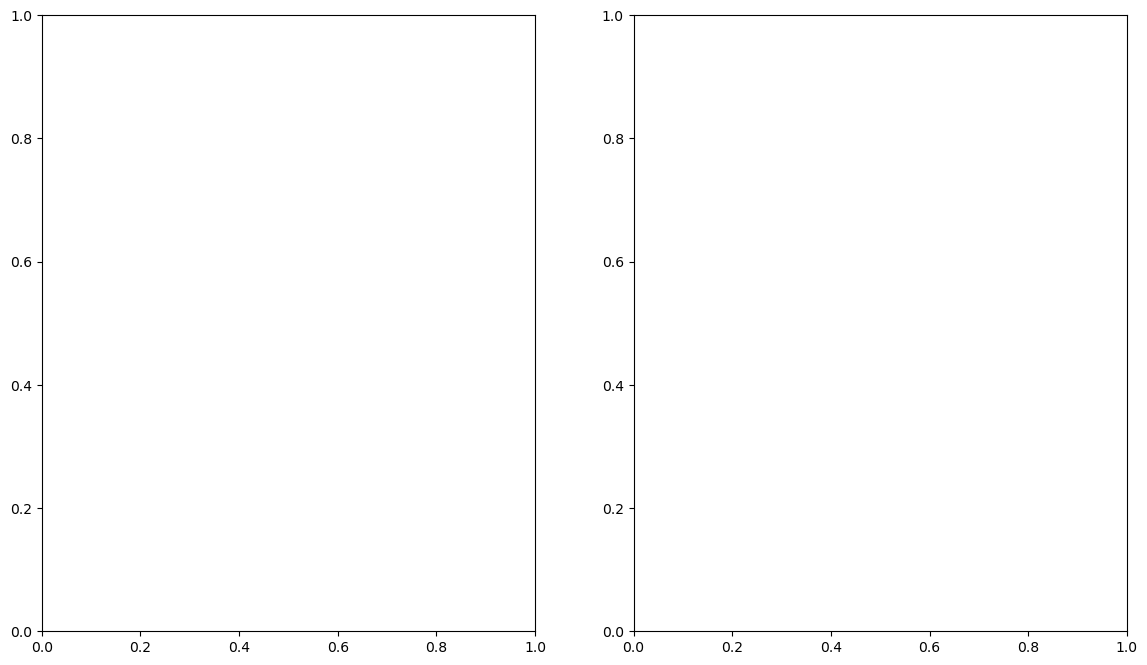

In [2]:
m = deaton(ngrid=100,nchgrid=250,sigma=.5,nquad=10, bellman_type='continuous')
print(m)
v,c = m.solve_plot(solver='timeiter')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

v,c = m.solve_plot(solver='vfi')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

m.bellman_type='discretized'
v,c = m.solve_plot(solver='vfi')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

Deaton model with beta=0.900, sigma=1.000, gross return=1.000
Grids: state 100 points up to 10.0, choice 250 points, quadrature 1 points
Interpolation: linear
The model is not solved.
|||

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in true_divide


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

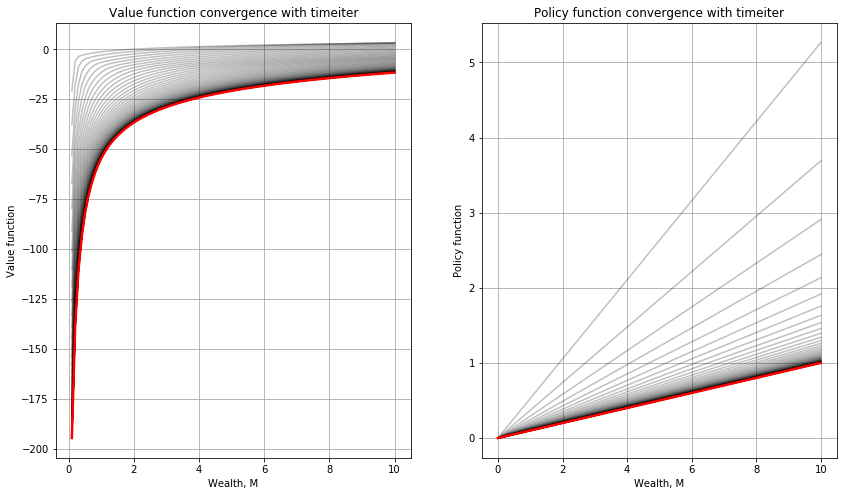

Average squared Euler residuals of the solution (time iterations) using 1000 points is 1.4981112258238239e-05


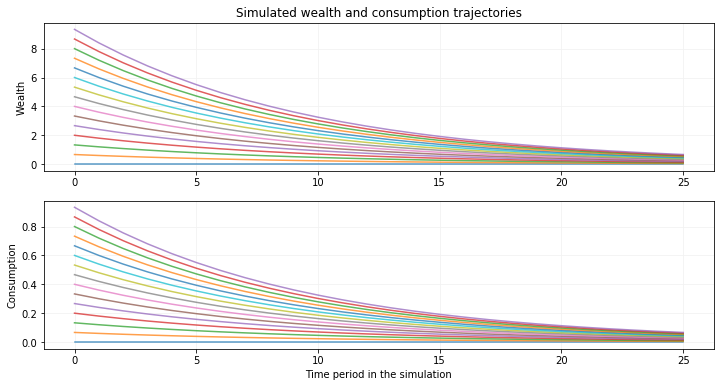

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

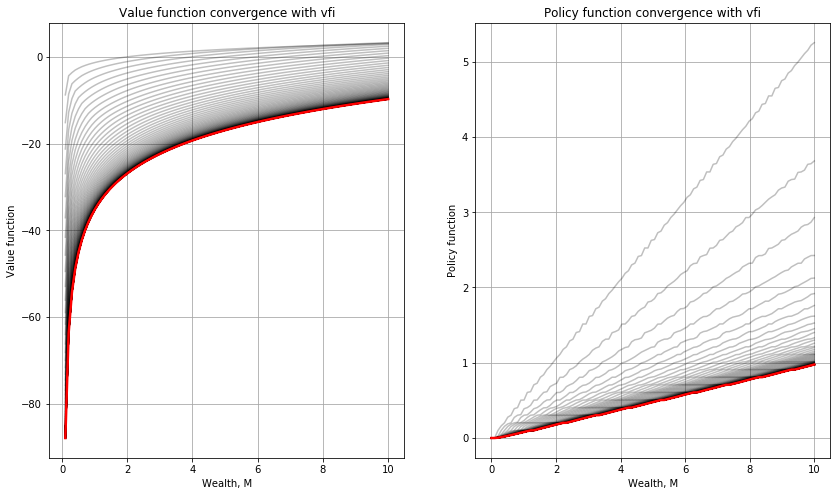

Average squared Euler residuals of the solution (VFI with continuous Bellman) using 1000 points is 8650.660106633046


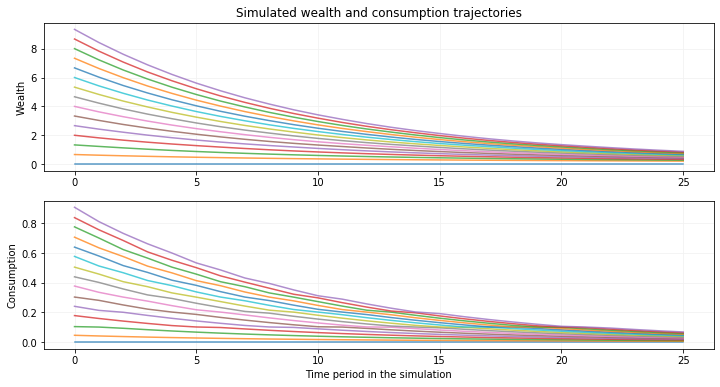

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

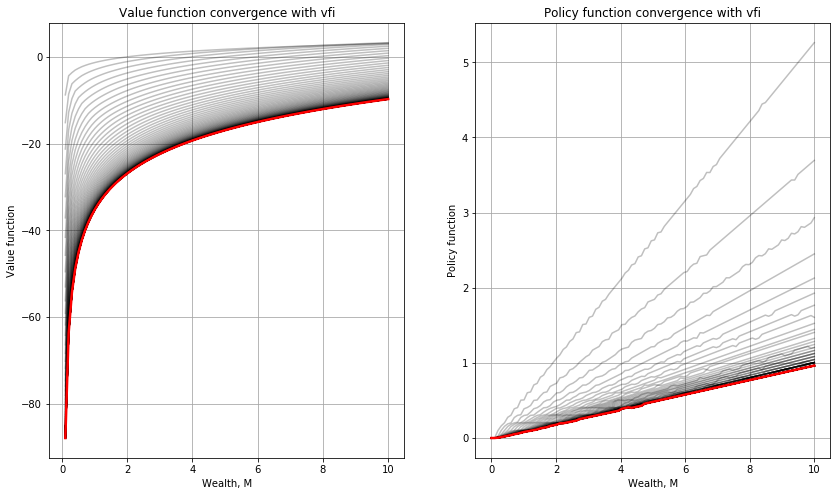

Average squared Euler residuals of the solution (VFI with discretized Bellman) using 1000 points is 8926.290761437984


In [ ]:
# same with no income and no returns on savings (cake eating)
m = deaton(ngrid=100,nchgrid=250,nquad=1,R=1., bellman_type='continuous')  # nquad=1 is special case with no income
print(m)
v,c = m.solve_plot(solver='timeiter')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

v,c = m.solve_plot(solver='vfi')
m.accuracy(verbose=True)
sims = m.simulator(init_wealth=m.Mbar*np.arange(15)/15,T=25,seed=2020)

m.bellman_type='discretized'
v,c = m.solve_plot(solver='vfi')
m.accuracy(verbose=True)

### Further learning resources

- Cake eating problem on QuantEcon [https://python.quantecon.org/cake_eating_problem.html](https://python.quantecon.org/cake_eating_problem.html)  
- Stochastic growth problem on QuantEcon [https://python.quantecon.org/optgrowth.html](https://python.quantecon.org/optgrowth.html)  
- Income fluctuation problem on QuantEcon [https://python.quantecon.org/ifp.html](https://python.quantecon.org/ifp.html)  